In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

sys.path.append(r"C:\Users\mikek\OneDrive\Project\DLS\DLS-git")
onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
from code_comparison.solps_pp import *

from DLScommonTools import *
from Morph import *
from Postprocess import *

%matplotlib inline
set_matplotlib_defaults()

%load_ext autoreload
%autoreload 2

# Here are some useful labels to use for plotting throughout notebook
store_labels = dict()
store_labels["cvar"] = {"density" : "$n_{u}\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}$"}
store_labels["crel"] = {"density" : "$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ /\ q_{\parallel0} (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_names =         {"density" : "$n_{u}\ /\ n_{u0}$",
                        "power" : "$q_{\parallel0}\ /\ q_{\parallel}$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_cnames =         {"density" : "$[n_{u}\ /\ n_{u0}]^{1}$",
                        "power" : "$[q_{\parallel0}\ /\ q_{\parallel}]^{5/7}$",
                        "impurity_frac" : "$[f_{z}\ /\ f_{z0}]^{0.5}$"}


st40_phys_viewer can not be loaded from outside Tokamak Energy!



# Read balance file

In [2]:
balance_path = r"C:\Users\mikek\OneDrive\Project\DLS\from_stuart\2023-07-11 - SPR45 balance file\balance.nc"
eqb = dict()
eqb["SPR45"] = dict()

for side in ["il", "ol", "iu", "ou"]: # Inner lower, outer lower.
    eqb["SPR45"][side] = unpackConfigurationMK(File = balance_path, Type = side, sepadd=1, resolution = 200)
    
    keys = list(eqb["SPR45"][side].keys())
    for key in keys:
        
        if key not in ["Bpol", "Btot", "Xpoint", "Spol", "S", "R", "Z"]:
            eqb["SPR45"][side].pop(key, None)
        
file_write(eqb, "equilibrium.pkl")

In [3]:
eqb = file_read("equilibrium.pkl")
data = eqb["SPR45"] # Pick design to use for study

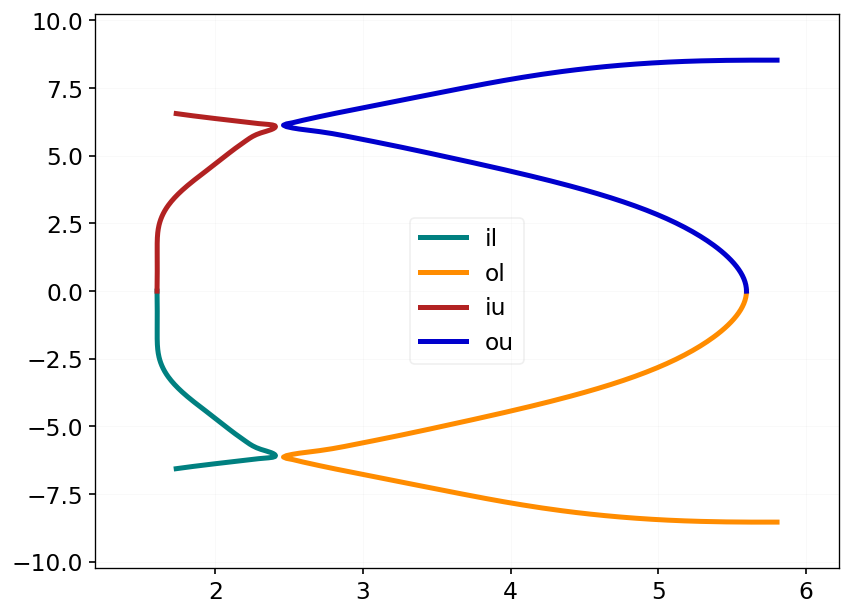

In [47]:
fig, ax = plt.subplots()
for side in ["il", "ol", "iu", "ou"]:
    ax.plot(data[side]["R"], data[side]["Z"], label = side)
    
ax.legend()

# Setup and run DLS

In [4]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, # Upstream density (if constant)
    "nu0" : 1e20, # Upstream density (if constant)
    "cz0" : 0.02, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbachAr, # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "alpha": 1000, # WIP - do not use. flux limiting alpha. Only matters if fluxlim is true
}

# Morph1: Move inner target down to outer target level

In [33]:
%matplotlib inline

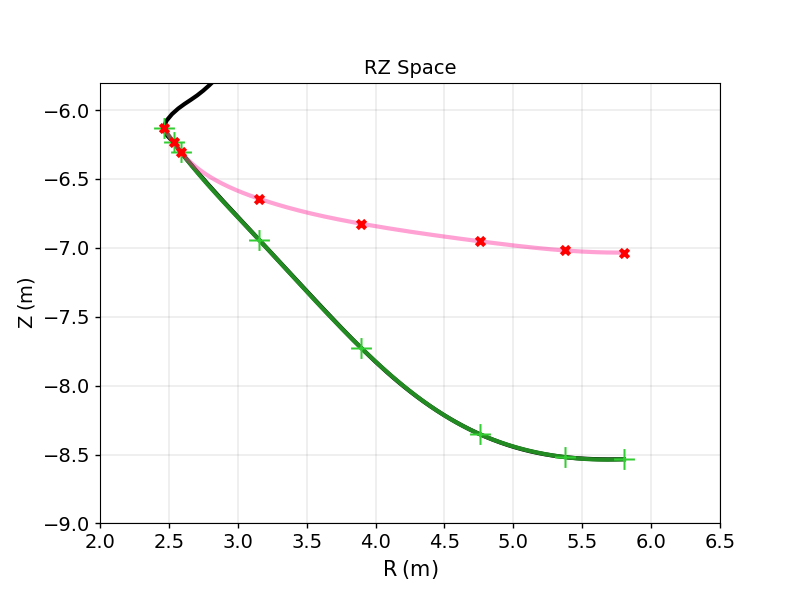

In [31]:
plt.close("all")

d = eqb["SPR45"]["ol"]
morph1 = Morph(d["R"], d["Z"], d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])
morph1.set_start_profile(
    [
    {"pos" : 1},
    {"pos" : 0.97},
    {"pos" : 0.95},
    {"pos" : 0.75},
    {"pos" : 0.5},
    {"pos" : 0.25},
    {"pos" : 0.10},
    {"pos" : 0.0},
    ]
)

morph1.set_end_profile(
    [
    {"pos" : 1,     "offsety": 0},
    {"pos" : 0.97,  "offsety": 0},
    {"pos" : 0.95,  "offsety": 0},
    {"pos" : 0.75,  "offsety": 0.3},
    {"pos" : 0.5,   "offsety": 0.9},
    {"pos" : 0.25,  "offsety": 1.4},
    {"pos" : 0.10,  "offsety": 1.5},
    {"pos" : 0.0,   "offsety": 1.5},
    ]
)

morph1.profs = morph1.generate_profiles(np.linspace(0,1,5))
morph1.plot_profile(morph1.end, xlim = (2,6.5), ylim = (-9, -5.8))

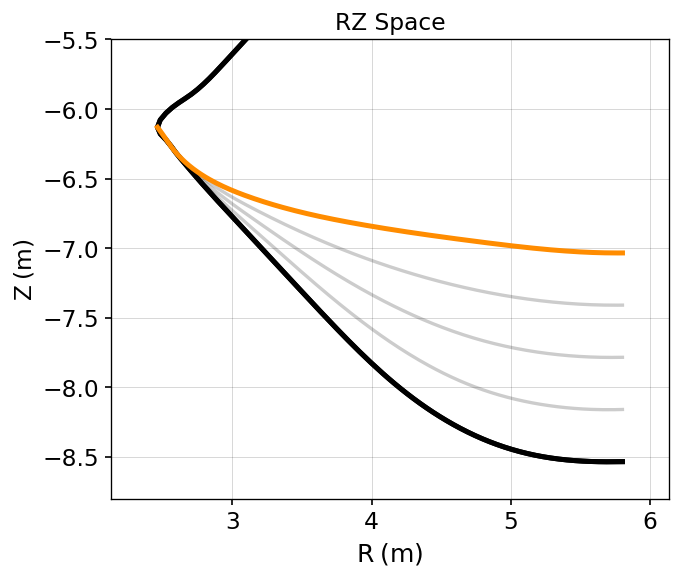

In [55]:

fig, ax = plt.subplots(1, figsize = (6,12))
morph = morph1
profs = {}
for p in morph.profiles:
    prof = morph.profiles[p]
    ax.plot(prof["xs"], prof["ys"], c = "black", zorder = 100, alpha = 0.2, lw = 2, ls = "-")

s = morph.start
e = morph.end
d_outer = eqb["SPR45"]["ol"]
ax.plot(morph.R, morph.Z, linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
ax.plot(d_outer["R"], d_outer["Z"], linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
# ax.plot(s["xs"], s["ys"], c = "teal", zorder = 100, alpha = 1)
ax.plot(e["xs"], e["ys"], c = "darkorange", zorder = 100, alpha = 1)
ax.set_xlabel("$R\ (m)$", fontsize = 15)
ax.set_ylabel("$Z\ (m)$")
ax.set_ylim(-8.8, -5.5)

alpha = 0.5
ax.set_title("RZ Space")
ax.grid(alpha = 0.3, color = "k")
ax.set_aspect("equal")

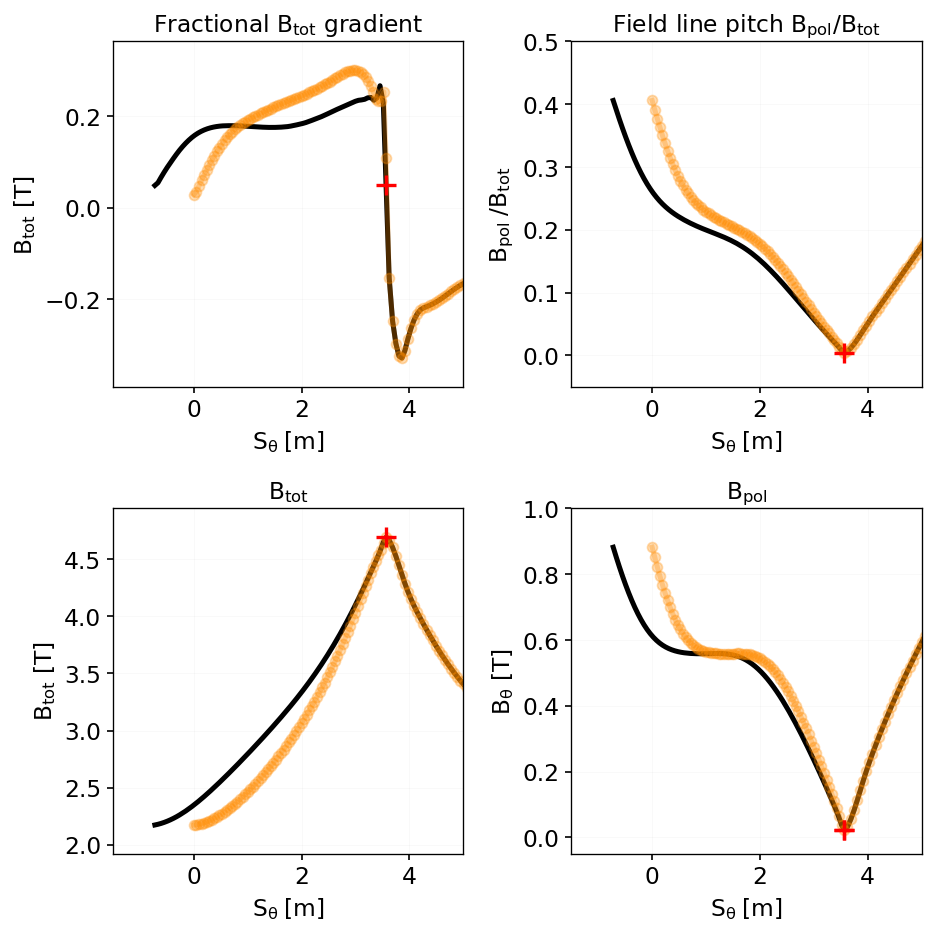

In [56]:

base_profile = morph1.start
profiles = [morph1.end]

fig, axes = plt.subplots(2,2, figsize = (8,8))
markers = ["o", "v"]

profstyle = dict(alpha = 0.3, color = "darkorange")

basestyle = dict(c = "black")
xstyle = dict(marker = "+", linewidth = 2, s = 150, c = "r", zorder = 100)

S_xpoint_max = max([p["S"][p["Xpoint"]] for p in profiles])
S_pol_xpoint_max = max([p["Spol"][p["Xpoint"]] for p in profiles])

Spol_shift_base = S_pol_xpoint_max - d["Spol"][d["Xpoint"]] 



ax = axes[0,0]
ax.set_title("Fractional $B_{tot}$ gradient")

ax.plot(d["Spol"] + Spol_shift_base, np.gradient(d["Btot"], d["Spol"]) / d["Btot"], **basestyle)
ax.scatter(d["Spol"][d["Xpoint"]] + Spol_shift_base, (np.gradient(d["Btot"], d["Spol"]) / d["Btot"])[d["Xpoint"]], **xstyle)
for i, p in enumerate(profiles): 
    Spol_shift = S_pol_xpoint_max  - p["Spol"][p["Xpoint"]]
    ax.plot(p["Spol"] + Spol_shift, np.gradient(p["Btot"], p["Spol"]) / p["Btot"], **profstyle, marker = markers[i])
    # ax.scatter(p["Spol"][p["Xpoint"]]+ Spol_shift, (np.gradient(p["Btot"], p["Spol"]) / p["Btot"])[p["Xpoint"]], **xstyle)
    ax.set_xlabel(r"$S_{\theta} \   [m]$");   
    ax.set_ylabel("$B_{tot}$ $[T]$")


ax = axes[1,0]
ax.set_title("$B_{tot}$")

ax.plot(d["Spol"] + Spol_shift_base, d["Btot"], **basestyle)
ax.scatter(d["Spol"][d["Xpoint"]] + Spol_shift_base, d["Btot"][d["Xpoint"]], **xstyle)
for i, p in enumerate(profiles): 
    Spol_shift = S_pol_xpoint_max  - p["Spol"][p["Xpoint"]]
    ax.plot(p["Spol"] + Spol_shift, p["Btot"], **profstyle, marker = markers[i])
    ax.set_xlabel(r"$S_{\theta} \   [m]$")
    ax.set_ylabel("$B_{tot}$ $[T]$")


ax = axes[0,1]

ax.set_title(r"Field line pitch $B_{pol}/B_{tot}$")
ax.plot(d["Spol"] + Spol_shift_base, d["Bpol"]/d["Btot"], **basestyle)
ax.scatter(d["Spol"][d["Xpoint"]]+ Spol_shift_base, (d["Bpol"]/d["Btot"])[d["Xpoint"]], **xstyle)
for i, p in enumerate(profiles): 
    Spol_shift = S_pol_xpoint_max  - p["Spol"][p["Xpoint"]]
    ax.plot(p["Spol"] + Spol_shift, p["Bpol"]/p["Btot"], **profstyle, marker = markers[i])
ax.set_xlabel(r"$S_{\theta} \   [m]$")
ax.set_ylabel(r"$B_{pol} \ / B_{tot}$ ")
ax.set_ylim(-0.05,0.5)

ax = axes[1,1]
ax.set_title("$B_{pol}$")

ax.plot(d["Spol"] + Spol_shift_base, d["Bpol"], **basestyle)
ax.scatter(d["Spol"][d["Xpoint"]] + Spol_shift_base,  (d["Bpol"])[d["Xpoint"]], **xstyle)
for i, p in enumerate(profiles): 
    Spol_shift = S_pol_xpoint_max  - p["Spol"][p["Xpoint"]]
    ax.plot(p["Spol"] + Spol_shift, p["Bpol"], **profstyle, marker = markers[i])
    ax.scatter(p["Spol"][p["Xpoint"]] + Spol_shift,  (p["Bpol"])[p["Xpoint"]], **xstyle)
ax.set_ylim(-0.05,1)
ax.set_xlabel(r"$S_{\theta} \   [m]$")
ax.set_ylabel(r"$B_{\theta}$ $[T]$")

for ax in [axes[0,0], axes[1,0], axes[0,1], axes[1,1]]:
    ax.set_xlim(-1.5,5)

fig.tight_layout()

In [57]:
cvar = "density"
design = "SPR45"
side = "ol"

store1 = dict()
# for cvar in ["power"]:
for cvar in ["density"]:
    
    for p in morph1.profiles:
        d = morph1.profiles[p].copy()

        # d = eqb[design][side].copy() # Load in single profile into dictionary "d"
        constants = constants_default.copy() # Set settings to default
        radios = radios_default.copy() # Set settings to default
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 10) # Solve at these parallel positions

        if "i" in side:
            constants["qpllu0"] = constants_default["qpllu0"] * 1.1 # Reduce power to 10% for the inner divertor to account for power sharing.

        results = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar, Ctol = 1e-3, Ttol=1e-3)
        
        store1[p] = copy.deepcopy(results)

Solving...0...24...42...55...63...68...71...72...73...74...Complete in 18.5 seconds
Solving...0...24...42...55...63...68...71...72...73...74...Complete in 18.7 seconds
Solving...0...25...42...55...63...68...71...72...73...74...Complete in 19.2 seconds
Solving...0...25...43...55...63...68...71...72...73...74...Complete in 19.4 seconds
Solving...0...25...43...55...63...68...71...72...73...74...Complete in 18.6 seconds


## Plot topology changes

In [31]:
BxBt

array([0.71804421, 0.71804421, 0.71804421, 0.71804421, 0.71804421])

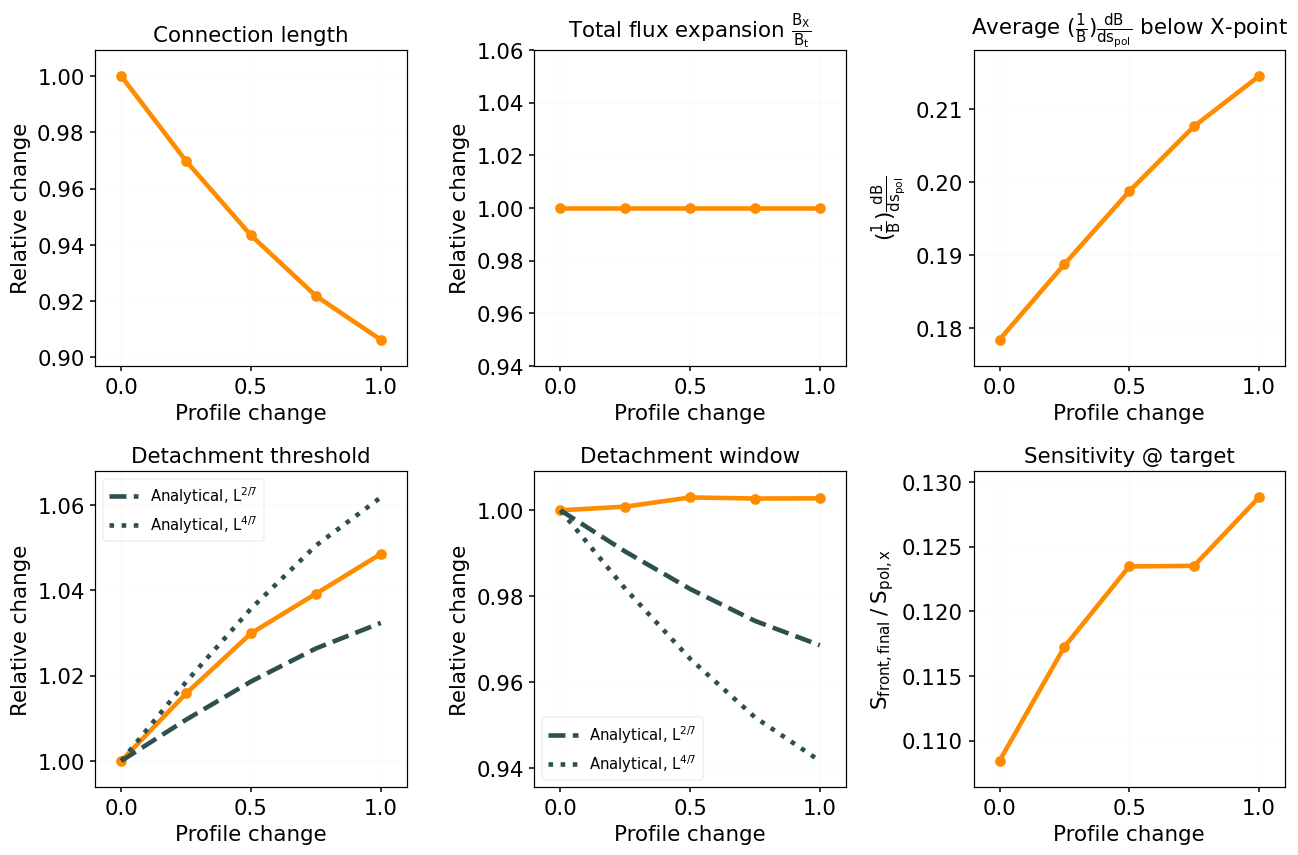

In [61]:
labels = ["Height", "Height and distance"]
colors = ["darkorange"]
stores = [store1]

windows = []

fig, axes = plt.subplots(2,3, dpi = 110, figsize = (12,8))

for i, morph in enumerate([morph1]):
    
    

    store = stores[i]
    windows = np.array([store[x]["window"] for x in morph.profiles])
    thresholds = np.array([store[x]["threshold"] for x in morph.profiles])
    L = np.array([morph.get_connection_length(morph.profiles[x]) for x in morph.profiles])
    BxBt = np.array([morph.get_total_flux_expansion(morph.profiles[x]) for x in morph.profiles])
    frac_gradB = np.array([morph.get_average_frac_gradB(morph.profiles[x]) for x in morph.profiles])
    avgB_ratio = np.array([morph.get_average_B_ratio(morph.profiles[x]) for x in morph.profiles])
    
    target_sens = np.array([morph.get_sensitivity(store[x]["crel_trim"], store[x]["SpolPlot"], fluctuation=1.05, location=0.0) for x in morph.profiles])
    
    if i == 0:
        L_base = L[0]
        BxBt_base = BxBt[0]
        threshold_base = thresholds[0]
        window_base = windows[0]
        avgB_ratio_base = avgB_ratio[0]
        
    threshcalc = (BxBt/BxBt_base)**(-1) * (L/L_base)**(-2/7) * (avgB_ratio/avgB_ratio_base)**(2/7)
    threshcalc2 = (BxBt/BxBt_base)**(-1) * (L/L_base)**(-4/7) * (avgB_ratio/avgB_ratio_base)**(2/7)
    
    windowcalc = (BxBt/BxBt_base)**(1) * (L/L_base)**(2/7) * (avgB_ratio/avgB_ratio_base)**(-2/7)
    windowcalc2 = (BxBt/BxBt_base)**(1) * (L/L_base)**(4/7) * (avgB_ratio/avgB_ratio_base)**(-2/7)
    
    index = np.linspace(0,1,5)+i
    
    
    
    index = np.linspace(0,1,5)+i
    axes[0,0].set_title("Connection length")
    axes[0,0].plot(index, L/L_base, marker = "o", color = colors[i])
    
    axes[0,1].set_title(r"Total flux expansion $\frac{B_{X}}{B_{t}}$")
    axes[0,1].plot(index, BxBt/BxBt_base, marker = "o", color = colors[i])
    
    axes[0,2].set_title(r"Average $(\frac{1}{B}) \frac{dB}{ds_{pol}}$ below X-point")
    axes[0,2].plot(index, frac_gradB, marker = "o", color = colors[i])
    
    axes[1,0].set_title(r"Detachment threshold")
    axes[1,0].plot(index, thresholds/threshold_base, marker = "o", color = colors[i])
    
    axes[1,0].plot(index, threshcalc, color = "darkslategrey", ls = "--", label = None if i == 1 else "Analytical, $L^{2/7}$")
    axes[1,0].plot(index, threshcalc2, color = "darkslategrey", ls = ":", label = None if i == 1 else "Analytical, $L^{4/7}$")
    axes[1,0].legend(fontsize = "x-small")
    
    axes[1,1].set_title(r"Detachment window")
    axes[1,1].plot(index, windows/window_base, marker = "o", color = colors[i])
    axes[1,1].plot(index, windowcalc, color = "darkslategrey", ls = "--", label = None if i == 1 else "Analytical, $L^{2/7}$")
    axes[1,1].plot(index, windowcalc2, color = "darkslategrey", ls = ":", label = None if i == 1 else "Analytical, $L^{4/7}$")
    axes[1,1].legend(fontsize = "x-small")
    
    axes[1,2].set_title(r"Sensitivity @ target")
    axes[1,2].plot(index, target_sens, marker = "o", color = colors[i])

for ax in axes.flatten():
    ax.set_xlabel("Profile change")

for ax in [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]:
    ax.set_ylabel("Relative change")

    
axes[0,2].set_ylabel(r"$(\frac{1}{B}) \frac{dB}{ds_{pol}}$")
axes[1,2].set_ylabel("$S_{front, final} \ /\  S_{pol, x}$")
fig.tight_layout()

In [25]:
target_sens

[None, None, None, None, None]

In [16]:
cases = dict(base = store1[0], stage1 = store1[1], stage2 = store2[1])

In [46]:
morph.get_sensitivity(store1[0]["crel_trim"], store1[0]["SpolPlot"], fluctuation=1.1, location=0.0, verbose = True)

Spol at location: 0.000
Crel at location: 0.793
Sensitivity: 0.000


0

## Front profiles

C:\Users\mikek\AppData\Local\Temp\ipykernel_32952\3610120344.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('winter', 5)


Text(0.5, 1.0, 'Front position response to upstream density')

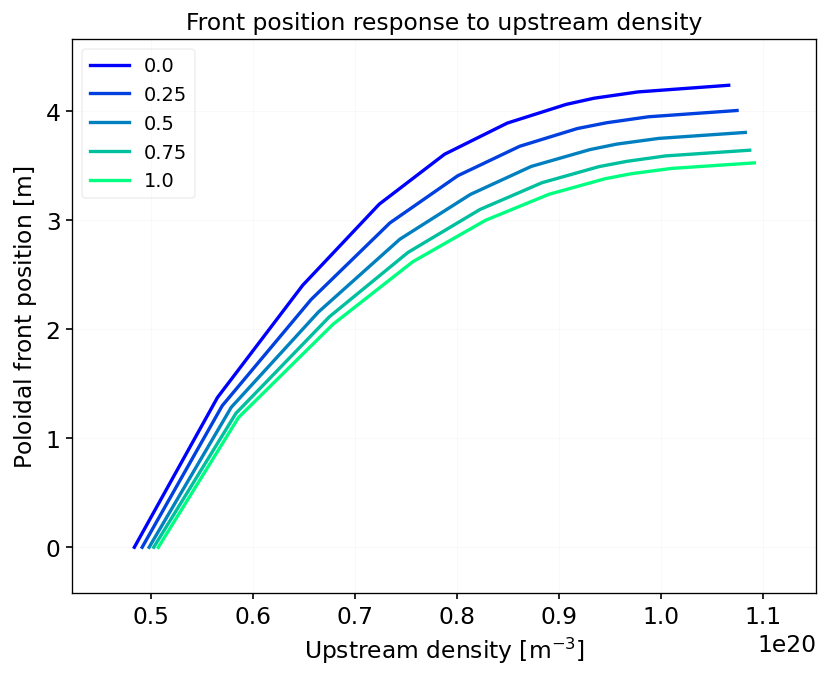

In [64]:
s = store1[0]

s.keys()

fig, ax = plt.subplots()
style = dict(lw = 2)
cmap = mpl.cm.get_cmap('winter', 5)
colors = [cmap(x) for x in np.linspace(0,1, len(morph1.profiles))]
for i, store in enumerate(morph1.profiles):
    s = store1[store]

    ax.plot(s["cvar_trim"], s["SpolPlot"], label = store, color = colors[i], **style)
    
    
# cmap = mpl.cm.get_cmap('Wistia', 5)
# colors = [cmap(x) for x in np.linspace(0,1, len(morph1.profiles))]
# for i, store in enumerate(morph2.profiles):
#     s = store2[store]

#     ax.plot(s["cvar_trim"], s["SpolPlot"], label = store+1, color = colors[i], **style)
    
ax.legend(fontsize = "small")
ax.set_xlabel("Upstream density $[m^{-3}]$")
ax.set_ylabel("Poloidal front position $[m]$")
ax.set_title("Front position response to upstream density")
# store2.keys()